# A equação de Navier-Stokes bidimensional

- PET - Física UFRN
- Petiano: Gabriel Wendell Celestino Rocha
- Data: 18 de Agosto de 2021

O objetivo deste `Notebook` é, em uma primeira instância, servir como um complemento ao `Notebook` *[convecção, difusão e a equação de Burgers](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Convecção%2C%20difusão%20e%20a%20equação%20de%20Burgers.ipynb)* [1]. Entretanto, o objetivo principal deste `Notebook` é avaliar computacionalmente a equação de Navier-Stokes bidimensional.

Para uma melhor organização deste `Notebook` como um todo, o mesmo foi dividido em duas seções:

- Ampliando o modelo bidimensional
- Resolvendo a equação de Navier-Stokes bidimensional
- Apêndice: Qual o significado do termo $F$?

Na primeira seção iremos avaliar e resolver a equação de Laplace, e em seguida, a equação de Poisson. Esta seção será de extrema importância pois na seção seguinte iremos juntar essas duas equações para trabalhar com a equação de Navier-Stokes bidimensional.

A segunda e última seção deste `Notebook` iremos resolver a equação de Navier-Stokes em duas dimensões, mas com diferentes condições de contorno das que serão apresentadas na primeira seção. Para isso, iremos abordar os problemas dos fluxos em uma cavidade e em um canal.

Além disso, haverá no fim deste `Notebook` um apêndice apresentando algumas explicações conceituais que corriqueiramente geram dúvidas e confusões naqueles que estão iniciando nos estudos de CFD (*Computational Fluid Dynamics*) e servirá como um complemento para a seção 2.

## Pré-requisitos

Tendo em vista que este `Notebook` visa servir de complemento ao `Notebook` presente na referência [1]. É indispensável ao leitor que, caso ainda não tenha lido tal `Notebook`, que o faça antes de prosseguir neste `Notebook` para um melhor entendimento do mesmo. Você pode checar tal `Notebook` na referência [1] ou clicando [aqui](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Convecção%2C%20difusão%20e%20a%20equação%20de%20Burgers.ipynb).

### Importando as bibliotecas necessárias

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import until

%matplotlib notebook

Detalhes das bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Until

Software versions
Python 3.7.11 64bit [GCC 7.5.0]
IPython 7.23.1
OS Linux 5.4.0 80 generic x86_64 with Zorin 15 bionic
Matplotlib 3.4.2
Numpy 1.19.5
Until 0.1.2
Tue Aug 17 18:16:45 2021 -03

# 1. Ampliando o modelo bidimensional

## 1.1 Equação de Laplace

Vamos dar uma olhada na equação de Laplace bidimensional:

$$\frac{\partial^{2} p}{\partial x^{2}}+\frac{\partial^{2}p}{\partial y^{2}}=0$$

Sabemos como discretizar uma derivada de 2ª ordem. Entretanto, pense nisso por um minuto - a equação de Laplace tem as características típicas dos fenômenos de difusão. Por esta razão, ela deve ser discretizada através de *diferenças centrais*, para que a discretização seja consistente com a física que queremos simular.

A equação discretizada é:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^{2}}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^{2}}=0$$

Observe que a equação de Laplace não possui dependência do tempo - não há $p^{n+1}$. Em vez de rastrear uma onda no tempo (como foi feito no `Notebook`: *[Convecção, difusão e a equação de Burgers](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Convecção%2C%20difusão%20e%20a%20equação%20de%20Burgers.ipynb)* [1]), a equação de Laplace determina o estado de um sistema sob as condições de contorno fornecidas.

Dos estudos acerca de Transferência de Calor, o leitor pode reconhecer a equação de Laplace como a equação do calor em estado estacionário.

Ao invés de calcular onde o sistema estará em um certo instante $t$, resolveremos iterativamente para $p_{i,j}^{n}$ até que o mesmo atenda a uma condição que especificamos. O sistema alcançará o equilíbrio apenas quando o número de iteração tender a $\infty$, mas podemos aproximar o estado de equilíbrio iterando até que a mudança entre uma iteração e a próxima seja *muito pequena*.

Vamos reorganizar a equação discretizada, resolvendo-a para $p_{i,j}^{n}$:

$$\boxed{p_{i,j}^{n}=\frac{\Delta y^{2}(p_{i+1,j}^{n}+p_{i-1,j}^{n})+\Delta x^{2}(p_{i,j+1}^{n}+p_{i,j-1}^{n})}{2(\Delta x^{2}+\Delta y^{2})}}$$

Usar os esquemas de diferenças centrais em ambas as direções é o método mais amplamente aplicado para o operador de Laplace. Também é conhecido como o **operador de diferença de cinco pontos**, em alusão ao seu estêncil.

Vamos resolver a equação de Laplace numericamente, assumindo um estado inicial de $p=0$ em todas as regiões. Em seguida, adicionaremos as condições de contorno da seguinte forma:

$$p=0\iff x=0\text{ };$$

$$p=y\iff x=2\text{ };$$

$$\frac{\partial p}{\partial y}=0\iff y=0,\text{ }1\text{ };$$

Nessas condições, existe uma solução analítica para a equação de Laplace:

$$\boxed{p(x,y)=\frac{x}{4}-4\sum_{n\in\{1,3,5,\ldots\}}^{\infty}\frac{1}{(n\pi)^{2}\sinh{2n\pi}}\cdot\sinh{n\pi x}\cdot\cos{n\pi y}}$$

### 1.1.1 Usando funções

Iremos definir duas funções: a primeira irá plotar nossos dados em um gráfico de projeção 3D. A segunda irá iterar para resolver para $p$ até que a mudança da norma $L_{1}$ de $p$ seja menor que um valor especificado.

In [3]:
def plot2D(x, y, p):
    fig = plt.figure(figsize=(11,7), dpi=100)
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
                          linewidth=0, antialiased=False)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)
    ax.view_init(30, 225)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')

A função `plot2D` recebe três argumentos: um vetor `x`, um vetor `y` e a nossa matriz `p`. Dados esses três valores, ele produz um gráfico de projeção 3D, define os limites do gráfico e nos fornece um bom ângulo de visão.

$$p_{i,j}^{n}=\frac{\Delta y^{2}(p_{i+1,j}^{n}+p_{i-1,j}^{n})+\Delta x^{2}(p_{i,j+1}^{n}+p_{i,j-1}^{n})}{2(\Delta x^{2}+\Delta y^{2})}$$

In [4]:
def Laplace2D(p, y, dx, dy, L1norm_target):
    L1norm = 1
    pn = np.empty_like(p)
    
    while L1norm > L1norm_target:
        pn = p.copy()
        p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
                         dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) /
                        (2 * (dx**2 + dy**2)))
        
        p[:, 0] = 0          # p = 0 em x = 0
        p[:, -1] = y         # p = y em x = 2
        p[0, :] = p[1, :]    # dp/dy = 0 em y = 0
        p[-1, :] = p[-2, :]  # dp/dy = 0 em y = 1
        L1norm = (np.sum(np.abs(p[:]) - np.abs(pn[:])) /
                 np.sum(np.abs(pn[:])))

    return p

A função `Laplace2D` recebe cinco argumentos: a matriz `p`, o vetor `y`, `dx`, `dy` e o valor `L1norm_target`. Este último valor define o quão próxima a matriz `p` deve estar em duas iterações consecutivas antes que o loop seja interrompido e retorne o valor de `p` calculado.

Comecemos declarando as variáveis necessárias para o problema:

In [5]:
nx = 31
ny = 31
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

Agora definimos as condições iniciais e os auxiliares do plot:

In [6]:
p = np.zeros((ny, nx))

x = np.linspace(0, 2, nx)
y = np.linspace(0, 1, ny)

Por fim, definimos as condições de contorno:

In [7]:
p[:, 0] = 0          # p = 0 em x = 0
p[:, -1] = y         # p = y em x = 2
p[0, :] = p[1, :]    # dp/dy = 0 em y = 0
p[-1, :] = p[-2, :]  # dp/dy = 0 em y = 1

Agora, vamos tentar usar a nossa função `plot2D` para visualizar nossas condições iniciais. Se a função tiver sido definida corretamente, devemos ser capazes de começar a digitar `plot2D` e pressionar a tecla `tab` para opções de auto-completamento. 

<IPython.core.display.Javascript object>


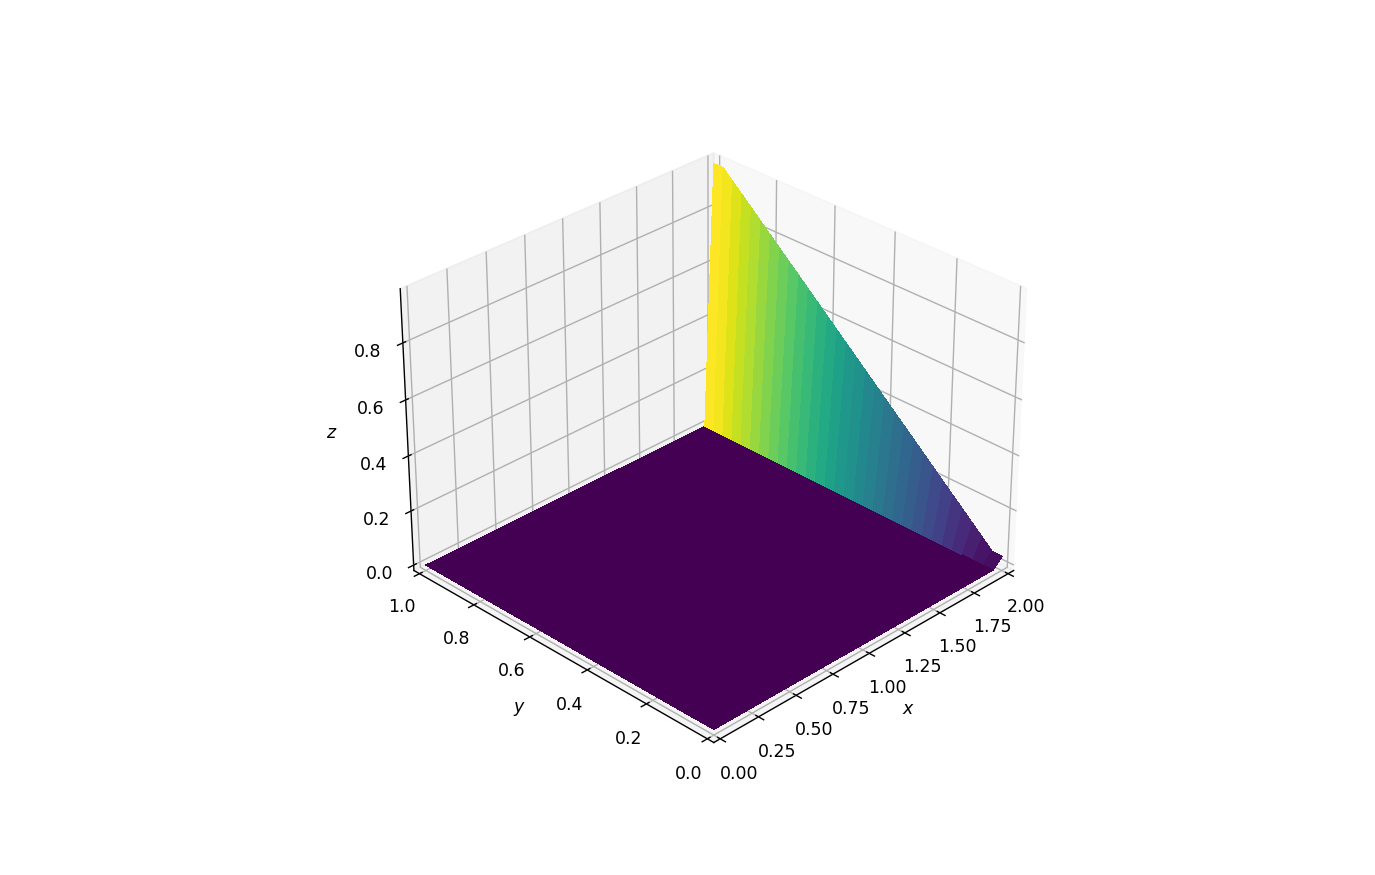

In [8]:
plot2D(x, y, p)
# plt.savefig('Condições iniciais.png')

Funcionou! Este é o estado inicial do nosso problema, onde o valor de `p` é zero em todos os lugares, exceto ao longo de $x=2$, onde $p=y$. Agora, vamos tentar executar nossa função `Laplace2D` com um destino $L_{1}$ especificado de 0.01.

[**Dica**: Caso você esteja tendo problemas para lembrar a ordem em que as variáveis são enviadas para uma determinada função, você pode simplesmente digitar `Laplace2D` (com isso o `Notebook` do `IPython` exibirá uma pequena caixa pop-up para lembrá-lo).]

In [9]:
p = Laplace2D(p, y, dx, dy, 1e-4)

Agora vamos tentar plotar esse novo valor de `p` com nossa função `plot2D`:

<IPython.core.display.Javascript object>


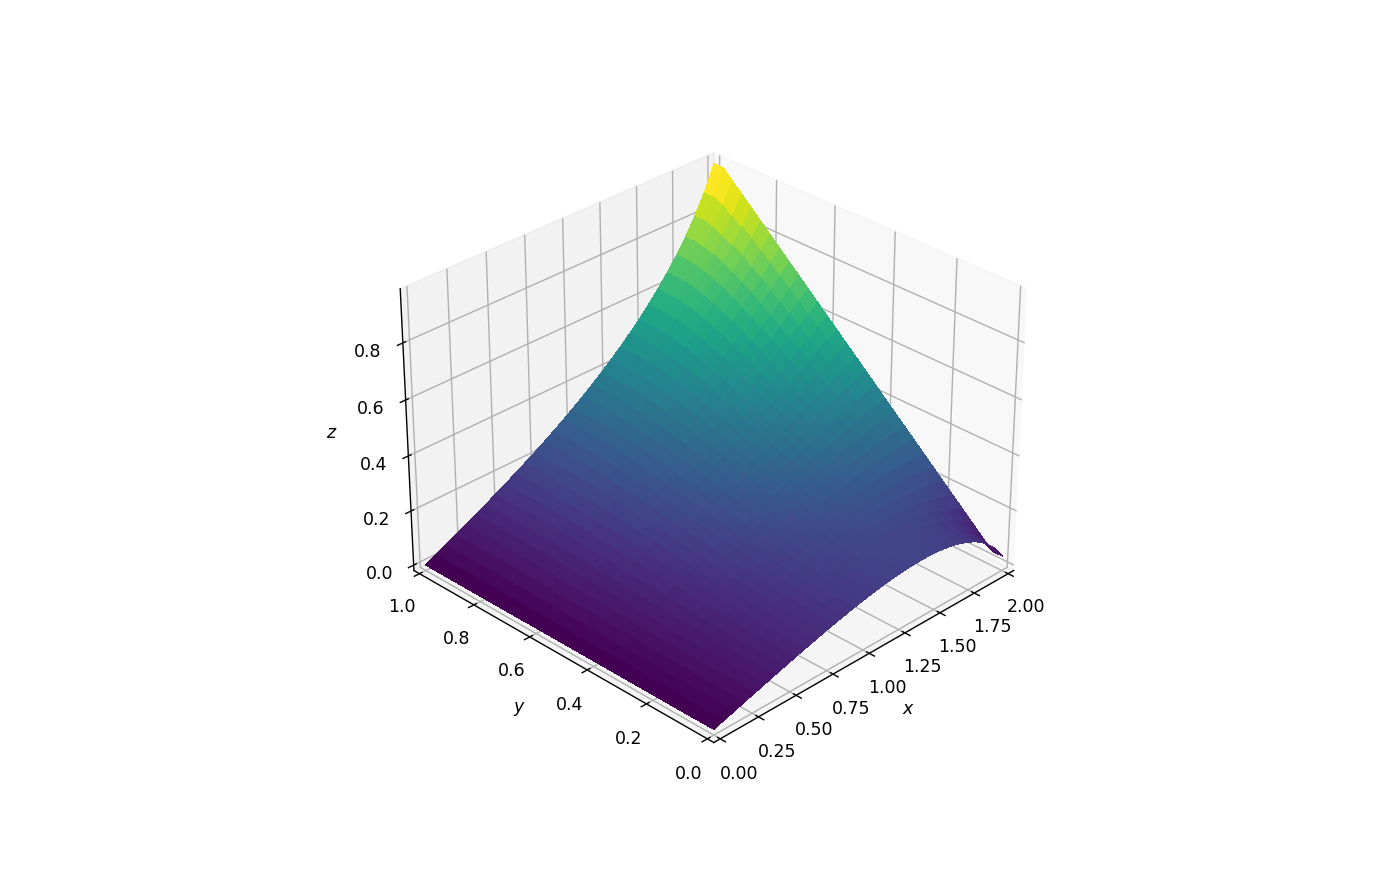

In [10]:
plot2D(x, y, p)
# plt.savefig('Condições iniciais - Eq. Laplace.png')

----

## 1.2 Equação de Poisson

Por um momento, lembre-se das equações de Navier-Stokes para um fluído incompressível, onde $\overrightarrow{v}$ representa o campo de velocidade:

$$\nabla\cdot\overrightarrow{v}=0$$

$$\frac{\partial\overrightarrow{v}}{\partial t}+(\overrightarrow{v}\cdot\nabla)\overrightarrow{v}-\frac{1}{\rho}\nabla p+\nu\nabla^{2}\overrightarrow{v}$$

A primeira equação representa a conservação da massa em densidade constante. Já a segunda equação representa a conservação do momento. Entretanto, surge um problema: a equação da continuidade para um fluxo incompressível não tem uma variável dominante e não há uma maneira óbvia de acoplar a velocidade e a pressão. No caso de um escoamento compressível, em constraste, a continuidade de massa forneceria uma equação de evolução para a densidade $\rho$, que é acoplada a uma equação de estado relacionando $\rho$ e $p$.

Em um fluxo incompressível, a equação da continuidade $\nabla\cdot\overrightarrow{v}=0$ fornece uma *restrição cinemática* que requer que o campo de pressão evolua de forma que a taxa de expansão $\nabla\cdot\overrightarrow{v}$ deve desaparecer em todas as regiões. Uma saída para essa dificuldade é construir um campo de pressão que garanta que a continuidade seja satisfeita. Tal relação pode ser obtida tomando a divergência da equação do momento. Nesse processo, uma **equação de Poisson** para a pressão nasce!

A equação de Poisson é obtida adicionando um termo de origem ao lado direito da equação de Laplace:

$$\frac{\partial^{2}p}{\partial x^{2}}+\frac{\partial^{2}p}{\partial y^{2}}=b$$

Portanto, ddiferentemente da equação de Laplace, há algum valor finito dentro do campo que afeta a solução. A equação de Poisson atua de forma a "relaxar" as fontes iniciais do campo.

Em sua forma discretizada, ela é quase idêntica à apresentada na subseção anterior, exceto pelo termo de origem:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^{2}}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^{2}}=b_{i,j}^{n}$$

Analogamente ao caso anterior, reorganizamos nossa equação para obter uma equação para $p$ no ponto $i,j$. Assim, obtemos:

$$\boxed{p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^{2}+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^{2}-b_{i,j}^{n}\Delta x^{2}\Delta y^{2}}{2(\Delta x^{2}+\Delta y^{2})}}$$

Resolveremos esta equação assumindo um estado inicial de $p=0$ em todas as regiões e aplicando as condições de contorno da seguinte forma:

$$p=0\iff x=0\text{, 2}\iff y=0\text{, 1}$$

Dessa forma, o termo de origem consiste em dois picos iniciais dentro do domínio, como segue abaixo:

$$b_{i,j}=100\iff i=\frac{1}{4}nx\text{ , }j=\frac{1}{4}ny$$

$$b_{i,j}=-100\iff i=\frac{3}{4}nx\text{ , }j=\frac{3}{4}ny$$

$$b_{i,j}=0\iff \text{ qualquer outra região}$$

As iterações avançarão em um pseudo-tempo para relaxar os picos iniciais. O relaxamento sobre a equação de Poisson se torna mais lento conforme eles progridem. Por quê?

Vejamos uma maneira possível de escrever o código para a equação de Poisson. Para isso, vamos inicialmente definir os nossos parâmetros:

In [11]:
nx = 50
ny = 50
nt = 100
xmin = 0
xmax = 2
ymin = 0
ymax = 1

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

Prosseguimos com a inicialização:

In [12]:
p = np.zeros((ny, nx))
pd = np.zeros((ny, nx))
b = np.zeros((ny, nx))
x = np.linspace(xmin, xmax, nx)
y = np.linspace(xmin, xmax, ny)

Definimos a nossa fonte:

In [13]:
b[int(ny/4), int(nx/4)] = 100
b[int(3 * ny/4), int(3 * nx/4)] = -100

Tendo feito isso, estamos prontos para avançar a estimativa inicial em um pseudo-tempo:

In [14]:
for it in range(nt):
    pd = p.copy()
    
    p[1:-1, 1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * dy**2 +
                     (pd[2:, 1:-1] + pd[:-2, 1:-1]) * dx**2 -
                     b[1:-1, 1:-1] * dx**2 * dy**2) /
                    (2 * (dx**2 + dy**2)))
    
    p[0, :] = 0
    p[ny - 1, :] = 0
    p[:, 0] = 0
    p[:, nx - 1] = 0

Aqui podemos reutilizar a nossa função para plotagem usada na subseção anterior com apenas alguma poucas modificações:

In [15]:
def plot2D_nolim(x, y, p):
    fig = plt.figure(figsize=(11, 7), dpi=100)
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

Agora vamos ao plot:

<IPython.core.display.Javascript object>


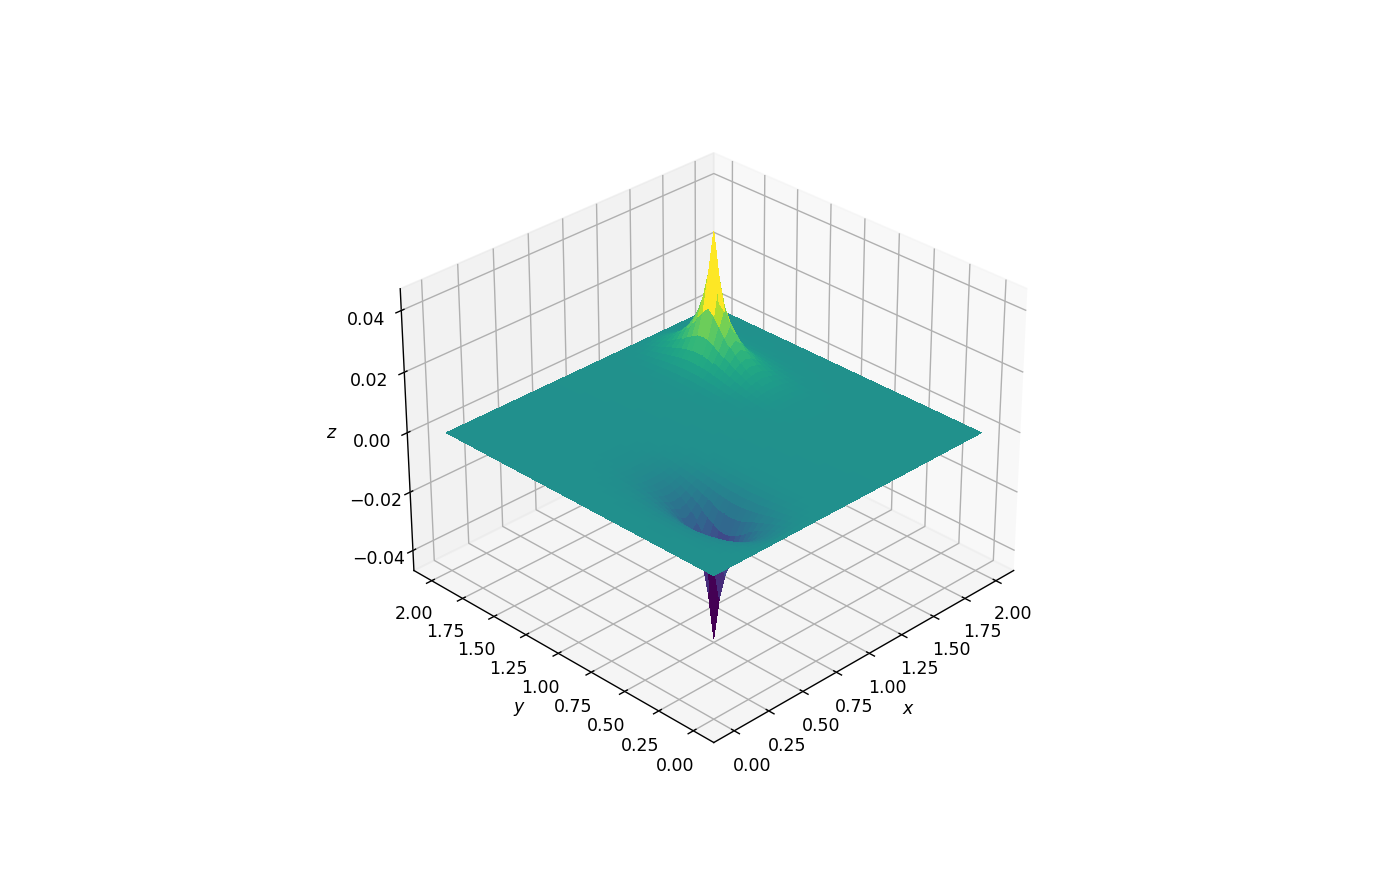

In [16]:
plot2D_nolim(x, y, p)
# plt.savefig('Condições iniciais - Eq. Poisson.png')

Ah! As maravilhas da reutilização de código! Agora, o leitor provavelmente deve estar pensando: "*Bem, se eu escrevi esta diminuta função que é capaz de fazer algo tão útil, então vale a pena usá-la indefinidamente. Como eu poderia realizar tal feito sem copiar e colar todas as vezes?*"

Para isso, basta que o leitor use os conceitos de embalagem (ou *packaging* em inglês). Para não irmos muito além do escopo e do objetivo deste `Notebook`, eis aqui um [link](https://packaging.python.org/overview/) [2] onde o leitor interessado pode conferir um *overview* sobre o *packaging* no Python.

---

# 2. Resolvendo a equação de Navier-Stokes bidimensional

## 2.1 Fluxo de uma cavidade com Navier-Stokes

Nesta seção iremos resolver a equação de Navier-Stokes em duas dimensões, mas com condições de contorno diferentes das que foram apresentadas até então.

A equação de momento em forma vetorial para um campo de valocidade $\overrightarrow{v}$ é:

$$\frac{\partial\overrightarrow{v}}{\partial t}+(\overrightarrow{v}\cdot\nabla)\overrightarrow{v}=-\frac{1}{\rho}\nabla p+\nu\nabla^{2}\overrightarrow{v}$$

Tal resultado representa três equações escalares, uma para cada componente de velocidade $(u,v,w)$. Entretanto, vamos no restringir à resolução dessas equações em duas dimensões, portanto, haverá duas equações escalares.

Aqui está o sistema de equações diferenciais: duas equações para as componentes da velocidade $u,v$ e uma equação para a pressão:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\Bigg(\frac{\partial^{2}u}{\partial x^{2}}+\frac{\partial^{2}u}{\partial y^{2}}\Bigg)$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\Bigg(\frac{\partial^{2}v}{\partial x^{2}}+\frac{\partial^{2}v}{\partial y^{2}}\Bigg)$$

$$\frac{\partial^{2}p}{\partial x^{2}}+\frac{\partial^{2}p}{\partial y^{2}}=-\rho\Bigg(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\Bigg)$$

Dos passos anteriores, já sabemos discretizar todos esses termos. Apenas a última equação que pode aparentar ser um tanto quanto "estranha". Mas com um pouco de paciência não será uma tarefa difícil discretizar tal equação!

### 2.1.1 Equações discretizadas

Primeiramente, vamos discretizar a equação do momentum $u$ da seguinte forma:

$$\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y}=-\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x}+\nu\Bigg(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^{2}}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^{2}}\Bigg)$$

Analogamente, obtemos para a equação do *momentum* $v$:

$$\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y}=-\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y}+\nu\Bigg(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^{2}}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^{2}}\Bigg)$$

Finalmente, a equação discretizada de Poisson para a pressão pode ser escrita como sendo:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^{2}}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^{2}}=\rho\Bigg[\frac{1}{\Delta t}\Bigg(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}-2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}$$

Recomenda-se ao leitor escrever essas equações em suas próprias notas, à mão, seguindo cada termo mentalmente à medida que o escreve.

Assim como antes, vamos reorganizar as equações da maneira que as iterações necessitam para continuar no código. Primeiramente, as equações de *momentum* para a velocidade na próxima etapa de tempo.

A equação do *momentum* na direção $u$ será:

$$u_{i,j}^{n+1}=u_{i,j}^{n}-u_{i,j}^{n}\frac{\Delta t}{\Delta x}\big(u_{i,j}^{n}-u_{i-1,j}^{n}\big)-v_{i,j}^{n}\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})-\frac{\Delta t}{2\rho\Delta x}\big(p_{i+1,j}^{n}-p_{i-1,j}^{n}\big)+\nu\Bigg[\frac{\Delta t}{\Delta x^{2}}\big(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\big)+\frac{\Delta t}{\Delta y^{2}}\big(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\big)\Bigg]$$

A equação do *momentum* na direção $v$ será:

$$v_{i,j}^{n+1}=v_{i,j}^{n}-u_{i,j}^{n}\frac{\Delta t}{\Delta x}\big(v_{i,j}^{n}-v_{i-1,j}^{n}\big)-v_{i,j}^{n}\frac{\Delta t}{\Delta y}\big(v_{i,j}^{n}-v_{i,j-1}^{n}\big)-\frac{\Delta t}{2\rho\Delta y}\big(p_{i,j+1}^{n}-p_{i,j-1}^{n}\big)+\nu\Bigg[\frac{\Delta t}{\Delta x^{2}}\big(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\big)+\frac{\Delta t}{\Delta y^{2}}\big(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\big)\Bigg]$$

Quase lá! Agora, vamos reorganizar a equação de Poisson para a pressão:

$$\boxed{p_{i,j}^{n}=\frac{\big(p_{i+1,j}^{n}+p_{i-1,j}^{n}\big)\Delta y^{2}+\big(p_{i,j+1}^{n}+p_{i,j-1}^{n}\big)\Delta x^{2}}{2\big(\Delta x^{2}+\Delta y^{2}\big)}-\frac{\rho\Delta x^{2}\Delta y^{2}}{2\big(\Delta x^{2}+\Delta y^{2}\big)}\times\Bigg[\frac{1}{\Delta t}\Bigg(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}-2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg]}$$

A condição inicial que iremos impor é que $u,v,p=0$ em todas as regiões, e as condições de contorno serão:

$$u=1\iff y=2$$

Note que essa condição de contorno atua como uma espécie de "tampa". Além disso, $u,v=0$ nas outras fronteiras:

$$\frac{\partial p}{\partial y}=0\iff y=0$$

$$p=0\iff y=2$$

$$\frac{\partial p}{\partial x}=0\iff x=0\text{, }2$$

Agora vamos tentar implementar todos esses extensivos resultados computacionalmente.

### 2.1.2 Implementando o fluxo de uma cavidade

Analogamente ao que foi feito na seção anterior, vamos definir os parâmetros, executar a inicialização e, por fim definir a nossa fonte:

In [17]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

A equação de Poisson de pressão escrita acima pode ser custosa de se escrever sem erros de digitação. A função `Build_Up_b` abaixo representa o conteúdo dos colchetes, de forma que a totalidade da equação parcial de pressão (PPE - do inglês *Partial Pressure Equation*) é um pouco mais gerenciável.

In [18]:
def Build_Up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

A função `Presssure_Poisson` também é definida de forma a ajudar na segregação dos diferentes ciclos de cálculos. Observe a presença da variável de pseudo-tempo `nit`. Esta sub-iteração no cálculo da equação de Poisson nos ajudará a garantir um campo livre de divergências.

In [19]:
def Pressure_Poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        
        p[:, -1] = p[:, -2]  # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]    # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]    # dp/dx = 0 at x = 0
        p[-1, :] = 0         # p = 0 at y = 2
        
        
    return p

Finalmente, o resto das equações de fluxo da cavidade estarão agrupadas dentro da função `Cavity_Flow`, o que nos permite plotar facilmente os resultados do solucionador do fluxo da cavidade para diferentes comprimentos de tempo.

In [20]:
def Cavity_Flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = Build_Up_b(b, rho, dt, u, v, dx, dy)
        p = Pressure_Poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # Velocidade na tampa da cavidade igual a 1.
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

Comecemos com `nt = 100` para avaliar o que o nosso solucionador nos retorna:

In [21]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

nt = 100
u, v, p = Cavity_Flow(nt, u, v, dt, dx, dy, p, rho, nu)

Agora vamos ao plot. Primeiramente, definimos uma função `opt_plot` que servirá para melhorar a estética dos nossos plots:

In [22]:
def opt_plot():
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                    top = True,right = True, length=5,width=1,labelsize=15)
    plt.tick_params(axis='both',which='major', direction = "in",
                    top = True,right = True, length=8,width=1,labelsize=15)

Agora vamos construir a nossa figura da seguinte forma:

- Traçamos o campo de pressão como um contorno;
- Plotamos os contornos do campo de pressão;
- Plotamos o campo de velocidades.

<IPython.core.display.Javascript object>


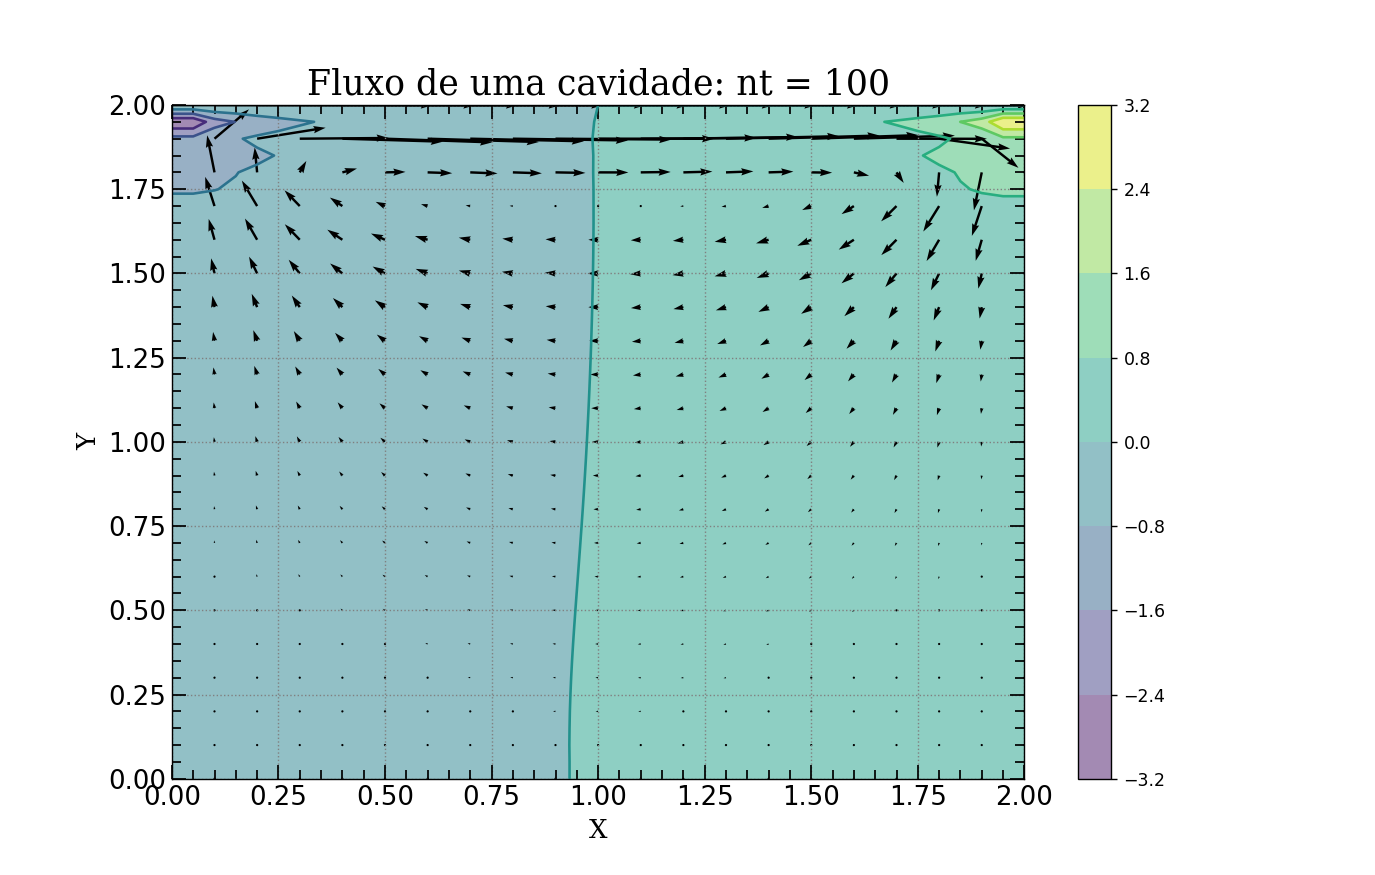

In [23]:
plt.figure(figsize=(11,7), dpi=100)

plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()

plt.contour(X, Y, p, cmap=cm.viridis)  

plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.title('Fluxo de uma cavidade: nt = 100', family='serif', fontsize=20)
plt.xlabel('X', family='serif', fontsize=15)
plt.ylabel('Y', family='serif', fontsize=15)

opt_plot()
# plt.savefig('Fluxo de cavidade - nt = 100.png')

Note que as duas zonas de pressão distintas estão se formando e que o padrão espiral esperado do fluxo da cavidade acionado pela tampa está aos poucos começando a se formar. Experimente diferentes valores para `nt` para avaliar quanto tempo o sistema leva para se estabilizar.

<IPython.core.display.Javascript object>


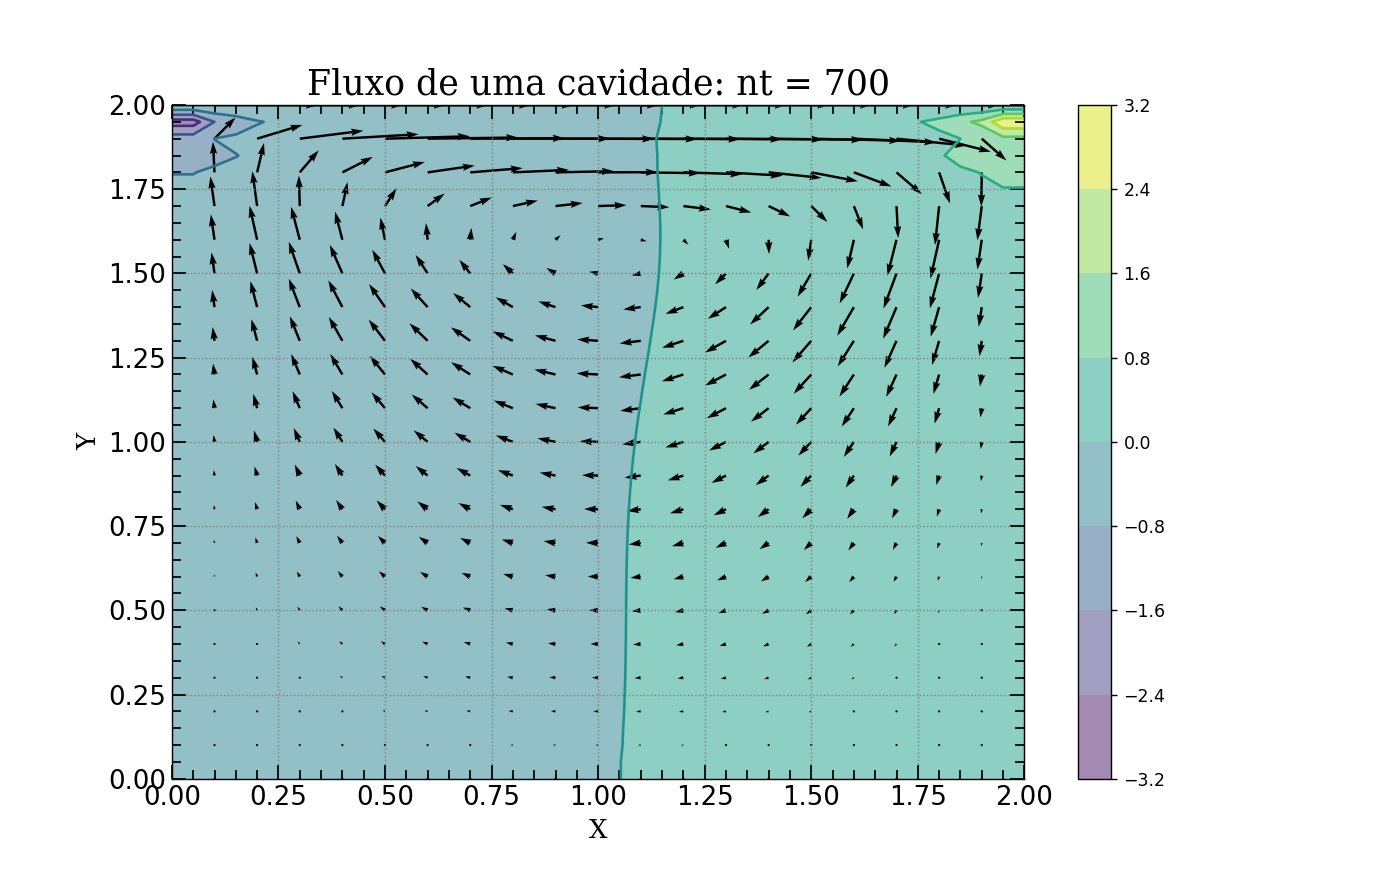

In [24]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

nt = 700
u, v, p = Cavity_Flow(nt, u, v, dt, dx, dy, p, rho, nu)

###############################################

plt.figure(figsize=(11,7), dpi=100)

plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()

plt.contour(X, Y, p, cmap=cm.viridis)  

plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.title('Fluxo de uma cavidade: nt = 700', family='serif', fontsize=20)
plt.xlabel('X', family='serif', fontsize=15)
plt.ylabel('Y', family='serif', fontsize=15)

opt_plot()
# plt.savefig('Fluxo de cavidade - nt = 700.png')

O gráfico do `quiver` mostra a magnitude da velocidade nos pontos discretos da grade da malha que foi criada (na verdade, estamos mostrando apenas metade dos pontos, uma vez que, do contrário, seria uma completa bagunça. A sintaxe `X[::2, ::2]` acima é uma maneira conveniente de solicitar todos os outros pontos).

Outra forma de visualizar o fluxo na cavidade é usar um `streamplot`:

<IPython.core.display.Javascript object>


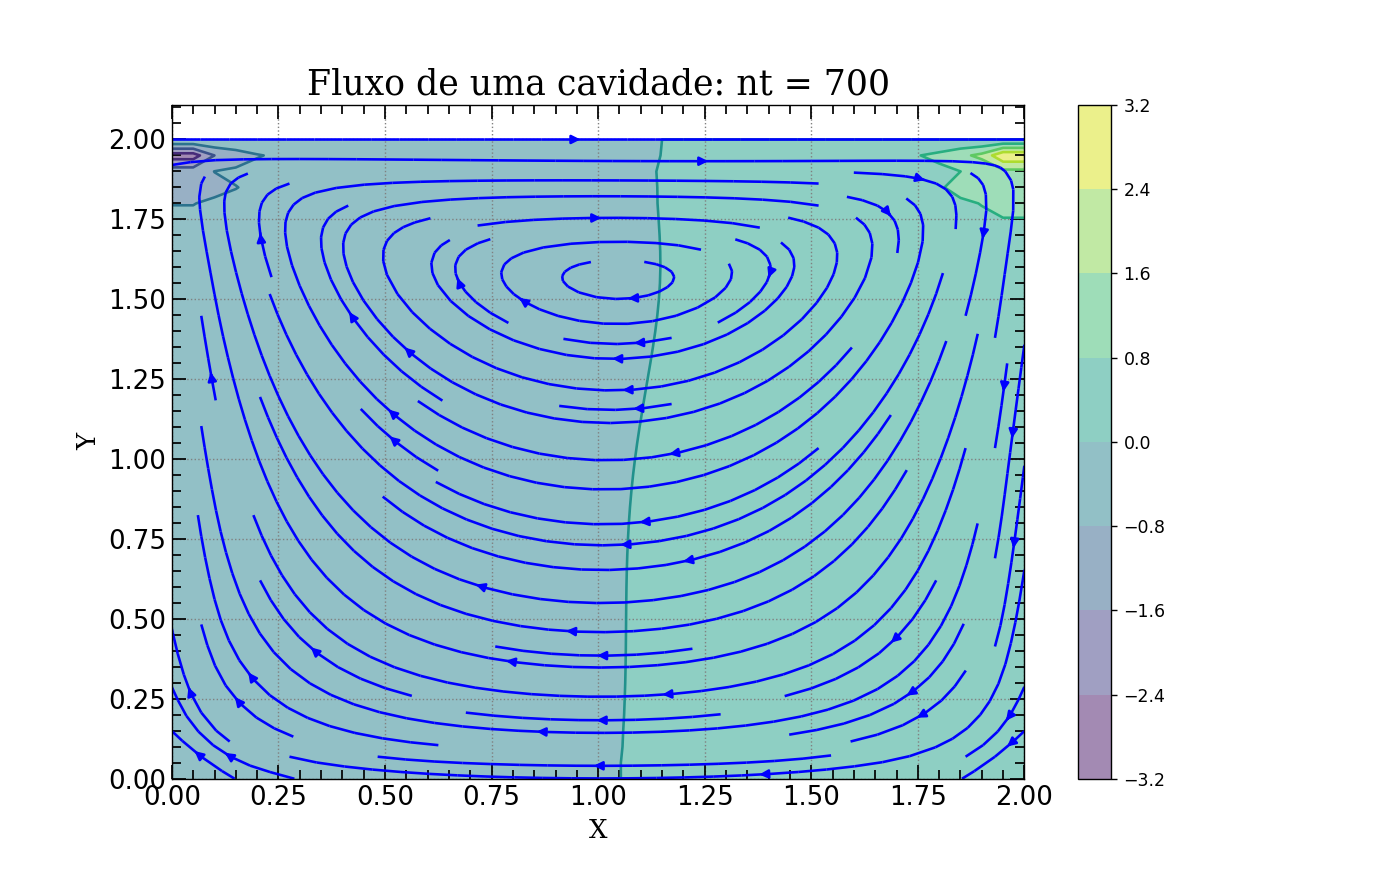

In [25]:
plt.figure(figsize=(11, 7), dpi=100)

plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()

plt.contour(X, Y, p, cmap=cm.viridis)

plt.streamplot(X, Y, u, v, color='blue')
plt.title('Fluxo de uma cavidade: nt = 700', family='serif', fontsize=20)
plt.xlabel('X', family='serif', fontsize=15)
plt.ylabel('Y', family='serif', fontsize=15)

opt_plot()
# plt.savefig('Fluxo de cavidade - nt = 700 (Streamplot).png')

---

## 2.2 Fluxo em um canal com Navier-Stokes

A única diferença entre essa esta etapa final e a etapa anterior é que aqui iremos adicionar um termo de origem à equação de *momentum* $u$, para simular o efeito de um fluxo de canal adionado por pressão. Eis aqui as nossas equações de Navier-Stokes modificadas:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\Bigg(\frac{\partial^{2}u}{\partial x^{2}}+\frac{\partial^{2}u}{\partial y^{2}}\Bigg)+F$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\Bigg(\frac{\partial^{2}v}{\partial x^{2}}+\frac{\partial^{2}v}{\partial y^{2}}\Bigg)+F$$

$$\frac{\partial^{2}p}{\partial x^{2}}+\frac{\partial^{2}p}{\partial y^{2}}=-\rho\Bigg(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\Bigg)$$

### 2.2.1 Equações discretizadas

Com paciência, carinho e cuidado, podemos escrever a forma discretizada das equações apresentadas acima. É altamente recomendável que você as escreve à mão, seguindo mentalmente cada termo à medida que o escreve.

A equação do *momentum* $u$ será:

$$\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y}=-\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x}+\nu\Bigg(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^{2}}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^{2}}\Bigg)+F_{i,j}$$

A equação do *momentum* $v$ será:

$$\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y}=-\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y}+\nu\Bigg(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^{2}}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^{2}}\Bigg)$$

Por fim, a equação da pressão será:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^{2}}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^{2}}=\rho\Bigg[\frac{1}{\Delta t}\Bigg(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}-2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta z}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg]$$

Como de costume, precisamos reorganizar essas equações para o formato cujo código necessita para realizar continuamente as iterações.

Para a equação de *momentum* $u$, isolamos a velocidade na etapa de tempo `n + 1`:

$$u_{i,j}^{n+1}=u_{i,j}^{n}-u_{i,j}^{n}\frac{\Delta t}{\Delta x}\big(u_{i,j}^{n}-u_{i-1,j}^{n}\big)-v_{i,j}^{n}\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})-\frac{\Delta t}{2\rho\Delta x}\big(p_{i+1,j}^{n}-p_{i-1,j}^{n}\big)+\nu\Bigg[\frac{\Delta t}{\Delta x^{2}}\big(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\big)+\frac{\Delta t}{\Delta y^{2}}\big(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\big)\Bigg]+\Delta tF$$

Analogamente para o *momentum* $v$:

$$v_{i,j}^{n+1}=v_{i,j}^{n}-u_{i,j}^{n}\frac{\Delta t}{\Delta x}\big(v_{i,j}^{n}-v_{i-1,j}^{n}\big)-v_{i,j}^{n}\frac{\Delta t}{\Delta y}\big(v_{i,j}^{n}-v_{i,j-1}^{n}\big)-\frac{\Delta t}{2\rho\Delta y}\big(p_{i,j+1}^{n}-p_{i,j-1}^{n}\big)+\nu\Bigg[\frac{\Delta t}{\Delta x^{2}}\big(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\big)+\frac{\Delta t}{\Delta y^{2}}\big(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\big)\Bigg]$$

Finalmente, para a equação de pressão, isolamos o termo $p_{i,j}^{n}$ para iterar no pseudo-tempo:

$$\boxed{p_{i,j}^{n}=\frac{\big(p_{i+1,j}^{n}+p_{i-1,j}^{n}\big)\Delta y^{2}+\big(p_{i,j+1}^{n}+p_{i,j-1}^{n}\big)\Delta x^{2}}{2\big(\Delta x^{2}+\Delta y^{2}\big)}-\frac{\rho\Delta x^{2}\Delta y^{2}}{2\big(\Delta x^{2}+\Delta y^{2}\big)}\times\Bigg[\frac{1}{\Delta t}\Bigg(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}-2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\Bigg]}$$

A condição inicial é $u,v,p=0$ em todas as regiões, onde $u,v,p$ são periódicas e nas condições de contorno temos:

$$u,v,p\iff x=0\text{, }2$$

$$u,v=0\iff y=0\text{, 2}$$

$$\frac{\partial p}{\partial y}=0\iff y=0\text{, 2}$$

$$F=1\iff \text{ qualquer outra região}$$

Assim como foi feito na subseção anterior, vamos tentar implementar todos esses extensivos resultados computacionalmente.

### 2.2.2 Implementando o fluxo de um canal

Na subseção anterior, isolamos uma parte de nossa equação transposta para facilitar a análise, faremos o mesmo aqui. É importante notar que temos condições de contorno periódicas em toda a nossa grade, por isso é necessário calcular explicitamente os valores nas bordas de ataque e de fuga de nosso vetor `u`.

In [26]:
def Build_Up_b_2(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Condição de contorno: Pressão periódica em x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Condição de contorno: Pressão periódica em x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    
    return b

Também definiremos uma função iterativa da equação de Poisson para a pressão, novamente como foi feito na subseção anterior. Analogamente, observe que temos que incluir as condições de contorno periódicas nas bordas de ataque e de fuga do vetor `u`. Além disso, é necessário especificar as condições de contorno na parte superior e inferior da grade.

In [27]:
def Pressure_Poisson_Periodic(p, dx, dy):
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Condição de contorno: Pressão periódica em x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Condição de contorno: Pressão periódica em x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Condições de contorno da parede: pressão
        p[-1, :] =p[-2, :]  # dp/dy = 0 em y = 2
        p[0, :] = p[1, :]   # dp/dy = 0 em y = 0
    
    
    return p

Agora temos uma lista familiar de variáveis e condições iniciais que devem ser declaradas antes de começar.

In [28]:
# Declaração de variáveis
nx = 41
ny = 41
nt = 10
nit = 50 
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)


# Variáveis físicas
rho = 1
nu = .1
F = 1
dt = .01


# Condições iniciais
u = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

p = np.zeros((ny, nx))
pn = np.zeros((ny, nx))

b = np.zeros((ny, nx))

Para a parte mais importante de nossa computação, vamos voltar a usar um truque que utilizamos na seção anterior para a equação de Laplace. Estamos interessados em como ficará a nossa grade quando atingirmos um estado quase estável. Podemos especificar um número de passos de tempo `nt` e incrementá-lo até que estejamos satisfeitos com os resultados, ou podemos dizer ao nosso código para ser executado até que a diferença entre duas iterações consecutivas seja muito pequena.

É necessário também que gerenciemos 8 condições de contorno separadas para cada iteração. O código a seguir descreve cada um deles explicitamente. Caso o leitor esteja interessado em um desafio, você pode tentar escrever uma função que possa lidar com algumas ou até todas essas condições de contorno. Se estiver interessado em lidar com isso, é recomendável que leia os [dicionários](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) [3] Python.

In [29]:
udiff = 1
stepcount = 0

while udiff > .001:
    un = u.copy()
    vn = v.copy()

    b = Build_Up_b_2(rho, dt, dx, dy, u, v)
    p = Pressure_Poisson_Periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Condição de contorno periódica: u em x = 2     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Condição de contorno periódica: u em x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Condição de contorno periódica: v em x = 2
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Condição de contorno periódica: v em x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


    # Condições de contorno da parede: u,v = 0 em y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :]=0
    
    
    udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
    stepcount += 1

Note que incluímos uma variável `stepcount` para avaliar quantas iterações nosso loop efetuou antes da condição de parada ser satisfeita.

In [30]:
print(stepcount)

499


Caso o leitor esteja interessado em avaliar como o número de iterações aumenta à medida que nossa condição `udiff` se torna cada vez menor, tente definir uma função para realizar o loop `while` escrito acima que recebe um `udiff` de entrada e produz o número de iterações que a função executa.

Por enquanto, vamos dar uma olhada em nossos resultados. Usamos a função `quiver` para observar os resultados do fluxo da cavidade e ela também funciona muito bem para o fluxo do canal.

<IPython.core.display.Javascript object>


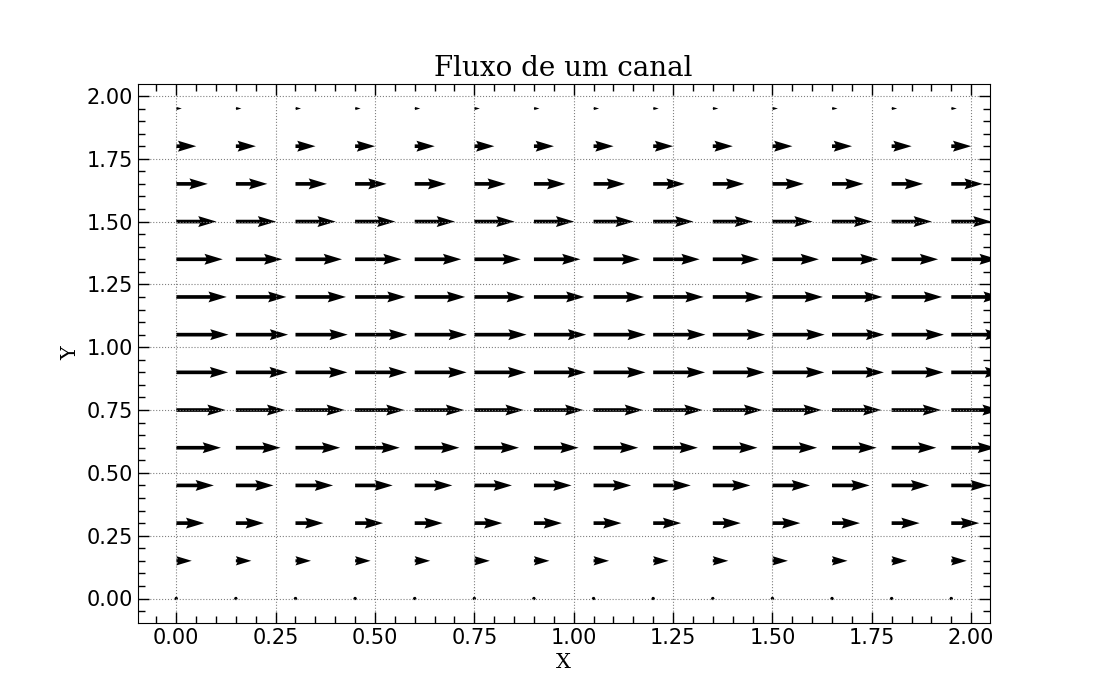

In [31]:
plt.figure(figsize = (11,7), dpi=100)

plt.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3])
plt.title(r'Fluxo de um canal', family='serif', fontsize=20)
plt.xlabel('X', family='serif', fontsize=15)
plt.ylabel('Y', family='serif', fontsize=15)

opt_plot()
# plt.savefig('Fluxo de canal.png')

As estruturas no comando `quiver` que se assemelham com `[::3, ::3]` são úteis ao lidar com grandes quantidades de dados nos quais você deseja visualizar. O usado acima informa ao `matplotlib` para plotar apenas cada terceiro ponto de dados. Se deixarmos isso de fora, os resultados podem aparentar um tanto quanto confusos.

<IPython.core.display.Javascript object>


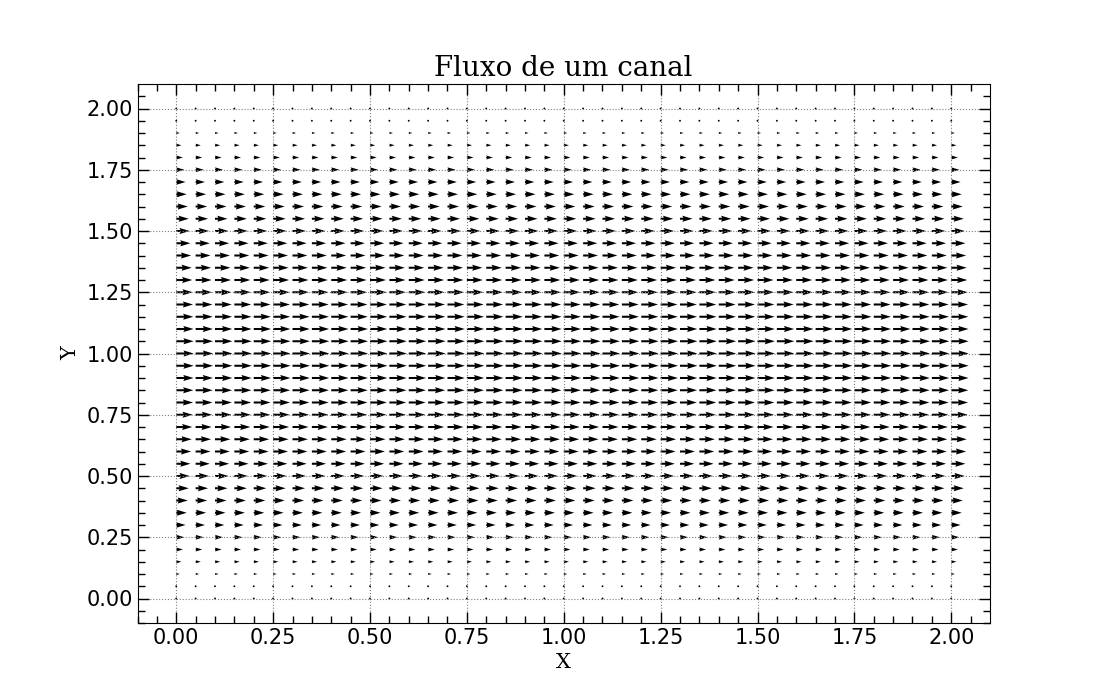

In [32]:
plt.figure(figsize = (11,7), dpi=100)

plt.quiver(X, Y, u, v)
plt.title(r'Fluxo de um canal', family='serif', fontsize=20)
plt.xlabel('X', family='serif', fontsize=15)
plt.ylabel('Y', family='serif', fontsize=15)

opt_plot()
# plt.savefig('Fluxo de canal - Geral.png')

Podemos também realizar o mesmo plot usando a função `streamplot`:

<IPython.core.display.Javascript object>


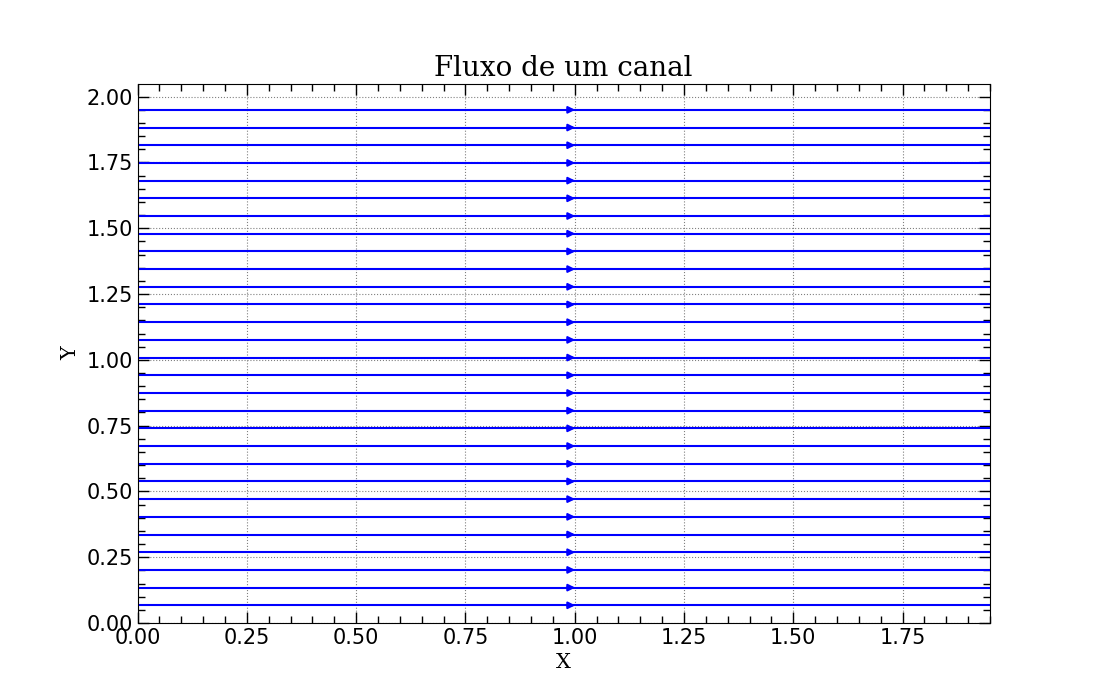

In [33]:
plt.figure(figsize = (11,7), dpi=100)

plt.streamplot(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3], color='blue')
plt.title(r'Fluxo de um canal', family='serif', fontsize=20)
plt.xlabel('X', family='serif', fontsize=15)
plt.ylabel('Y', family='serif', fontsize=15)

opt_plot()
# plt.savefig('Fluxo de canal (Streamplot).png')

---

## Apêndice: Qual é o significado do termo $F$?

A seção anterior é um exercício que demonstra o problema de fluxo em um canal ou tubo. Dos estudos de Mecânica dos Fluídos, um gradiente de pressão específicado é o que impusional o fluxo de Poisseulle.

Relembrando da equação do *momentum* $x$:

$$\boxed{\frac{\partial u}{\partial t}+u\cdot\nabla u=-\frac{\partial p}{\partial x}+\nu\nabla^{2}u}$$

O que realmente foi feito na subseção anterior foi dividir a pressão em componentes constantes e instáveis $p=P+p'$. O gradiente de pressão constante aplicado é a constante $-\frac{\partial P}{\partial x}=F$ (interpretado como um termo de origem), e o componente instável é $\frac{\partial p'}{\partial x}$. Portanto, a pressão que resolvemos na seção anterior é na verdade $p'$, que para um fluxo constante é de fato igual a zero em todas as regiões.

### Por que fazer isso?

Observe que usamos condições de contorno periódicas para este fluxo. Para um fluxo com gradiente de pressão constante, o valor da pressão na borda esquerda do domínio deve ser diferente da pressão na borda direita. Portanto, não podemos aplicar condições de contorno periódicas na pressão diretamente. É mais fácil corrigir o gradiente e então resolver as perturbações na pressão.

### Não deveríamos sempre esperar um $p'$ uniforme/constante então?

Isso é verdade apenas no caso de fluxos laminares estáveis. Para [números de Reynolds](https://www.sciencedirect.com/topics/engineering/reynolds-number) [4] altos, os fluxos nos canais podem se tornar **turbulentos** e veremos flutuações instáveis na pressão, o que resultará em valores diferentes de zero para $p'$.

Na subseção 2.2, observe que o campo de pressão em si não é constante, mas o campo de perturbação de pressão é. O campo de pressão varia linearmente ao longo do canal com inclinação igual ao gradiente de pressão. Além disso, para fluxos incompressíveis, o valor absoluto da pressão é irrelevante.

---

#### Para aprofundar...

Para um aprofundamento de outras componentes de CFD (*Computational Fluid Dynamics*), você pode explorar a seção *Resources* da versão de primavera (*Spring Version*) de 2013 do curso no site da [Piazza](https://piazza.com/bu/spring2013/me702/resources).

---

# Referências

[1] *Convecção, difusão e a equação de Burgers* : https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Convecção%2C%20difusão%20e%20a%20equação%20de%20Burgers.ipynb

[2] *An Overview of Packaging for Python* : https://packaging.python.org/overview/

[3] *Python Dictionaries* : https://docs.python.org/2/tutorial/datastructures.html#dictionaries

[4] *Reynolds' Number*: https://www.sciencedirect.com/topics/engineering/reynolds-number

[5] *Piazza Course Site*: https://piazza.com/bu/spring2013/me702/resources

---